# Cel ćwiczenia

Tematem tego ćwiczenia jest analiza danych. Jego celem jest wybranie danych z UCI Machine Learning Repository, przedstawienie ich, a następnie przeprowadzenie na ich podstawie analizy danych. Poruszane zostaną zarówno zagadnienia dotyczące klasyfikacji jak i klasteryzacji.  

# Propozycja rozwiązania zadania

Najpierw należy znaleźć odpowiednie dane w celu wykonania dalszej części zadania. Zostały wybrane dane o nazwie seeds - https://archive.ics.uci.edu/ml/datasets/seeds#.
W celu analizy wybranych danych wykorzystano poniższe biblioteki oraz moduły.

In [1]:
#potrzebne biblioteki
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn.linear_model import LogisticRegression
import scipy.cluster.hierarchy as shc
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold import MDS

Sprawozdanie zostało stworzone za pomocą środowiska Jupyter Notebook, a jego wynik przy pomocy systemu LaTex zostanie wyeksportowany do pliku pdf. W celu wyśrodkowania tekstu i wykresów użyto poniższego kodu.

In [2]:
#wyśrodkowanie
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Opis przebiegu ćwiczenia

## Przedstawienie danych

Dane użyte w badaniu, jak już wspomniano powyżej, pochodzą z UCI Machine Learning Repository. Zawierają one informacje na temat 3 odmian ziaren pszenicy: Kama, Rosa oraz Canadian. Za pomocą miękkiego promieniowania rentgenowskiego udało się stworzyć wysokiej jakości wizualizację wewnętrznej struktury ziarna. Jest to metoda niedestrukcyjna oraz znacząco tańsza od bardziej zaawansowanych technik. Badania zostały przeprowadzone w Instytucie Agrofizyki Polskiej Akademii Nauk w Lublinie na ziarnach pszenicy pochodzących z pól doświadczalnych.

Poniżej wczytano dane.

In [3]:
#wczytanie danych
seeds = pd.read_csv('seeds_dataset.txt', sep='\t', lineterminator='\n', header=None, names=['area', 'perimeter','compactness','length of kernel','width of kernel','asymmetry','length of kernel groove','type'])

Przedstawiono poniżej strukturę danych. Jak widać zbiór danych zawiera 210 obserwacji oraz 8 zmiennych, z czego jedna to typ ziaren.

In [4]:
seeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   area                     210 non-null    float64
 1   perimeter                210 non-null    float64
 2   compactness              210 non-null    float64
 3   length of kernel         210 non-null    float64
 4   width of kernel          210 non-null    float64
 5   asymmetry                210 non-null    float64
 6   length of kernel groove  210 non-null    float64
 7   type                     210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.2 KB


Na podstawie wyżej opisanego badania dla każdego ziarna pszenicy zmierzone zostało 7 geometrycznych parametrów:

* area - powierzchnia ziarna,

* perimeter - obwód ziarna,

* compactness - zwięzłość kształtu ziarna, obliczana według wzoru:  $$\frac{4*\pi*area}{perimeter^2}$$

* length of kernel - długość ziarna,

* width of kernel - szerokość ziarna,

* asymmetry coefficient - współczynnik asymetrii ziarna,

* length of kernel groove - długość żłobienia ziarna.

Wszystkie wyżej wymienione parametry są zmiennymi numerycznymi zmiennoprzecinkowymi. Zmienna *type* to zmienna objaśniana - typ ziarna pszenicy. Przyjmuje ona wartości:

* 1 - typ Kama,

* 2 - typ Rosa,

* 3 - typ Canadian.

Poniżej przedstawiono pierwsze 5 obserwacji.

In [5]:
seeds.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


Poniżej przedstawiono statystyki opisowe atrybutów.

In [6]:
seeds.drop('type', axis=1).describe()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry,length of kernel groove
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000


Na podstawie powyższych statystyk można zaobserwować, iż nie wstępują braki w danych. Można również stwierdzić, iż dane są względnie równomiernie rozłożone - na pierwszy rzut oka można się spodziewać braku wartości odstających. 

Poniżej wykres przedstawiający ilość obserwacji w poszczególnych typach ziaren.

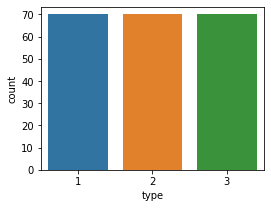

In [7]:
plt.figure(figsize=(4,3))
sns.countplot(seeds['type'])
plt.show()

Jak widać dane są równo podzielone - każda z grup posiada 70 obserwacji. Jest to bardzo sprzyjające dalszej części badania, pożądane jest równomierne rozłożenie obserwacji w grupach. 

Poniżej, w celu wizualizacji statystyk opisowych atrybutów, przedstawiono ich wykresy pudełkowe.

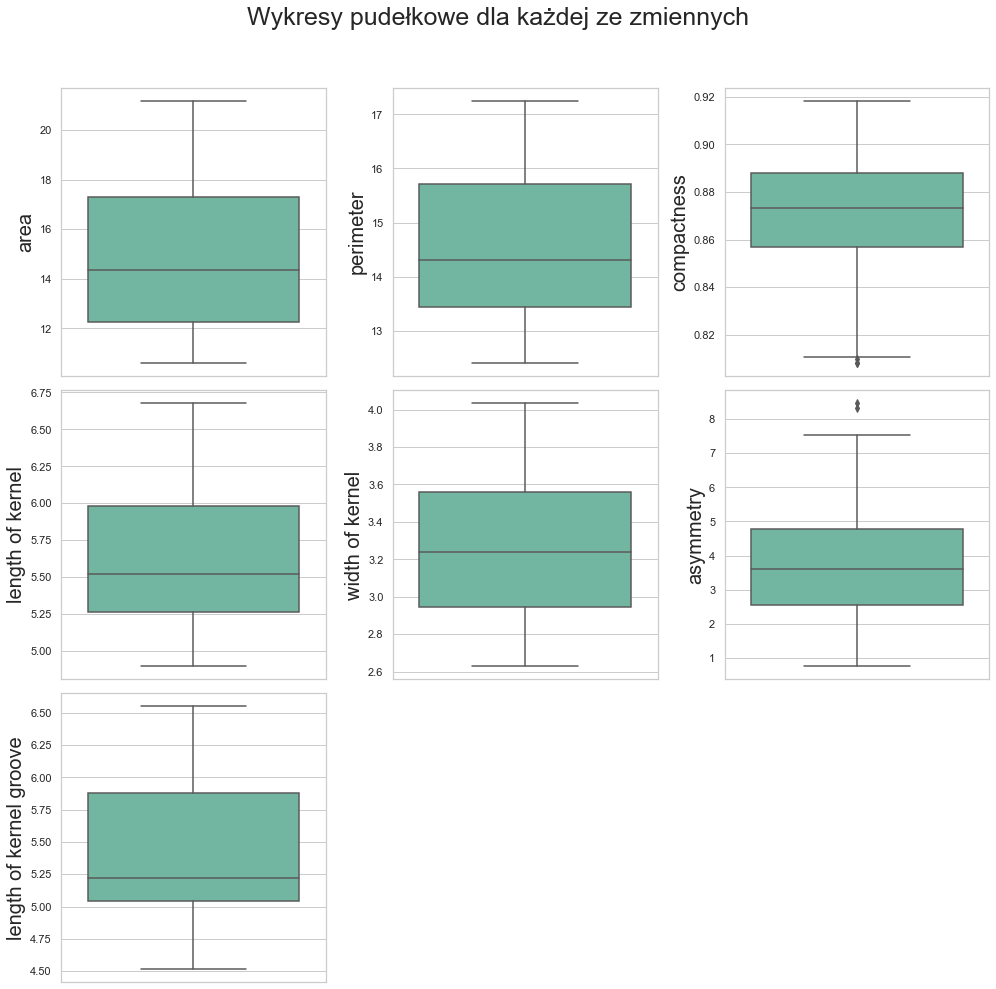

In [8]:
#nazwy zm. objaśiających
feature_names = ['area', 'perimeter','compactness','length of kernel','width of kernel','asymmetry','length of kernel groove']
#styl seaborn
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(14,14))
fig.suptitle('Wykresy pudełkowe dla każdej ze zmiennych', fontsize=25)

for i, el in enumerate(feature_names):
    sns.boxplot(el,data=seeds, ax=axes.flatten()[i], orient='v', palette="Set2")
    axes.flatten()[i].set_ylabel(el,fontsize=20)
#usunięcie pustych ax
fig.delaxes(axes[2,1])
fig.delaxes(axes[2,2])
plt.tight_layout() 
fig.subplots_adjust(top=0.90)

plt.show()    

Można zaobserwować, iż tylko w przypadku dwóch zmiennych można zaobserwować po 2 dwie wartości odstające. Nie są to jednak duże róznice. Postanowiono, więc nie pozbywać się ich. 

Poniżej przedstawiono histogramy dla atrybutów. 

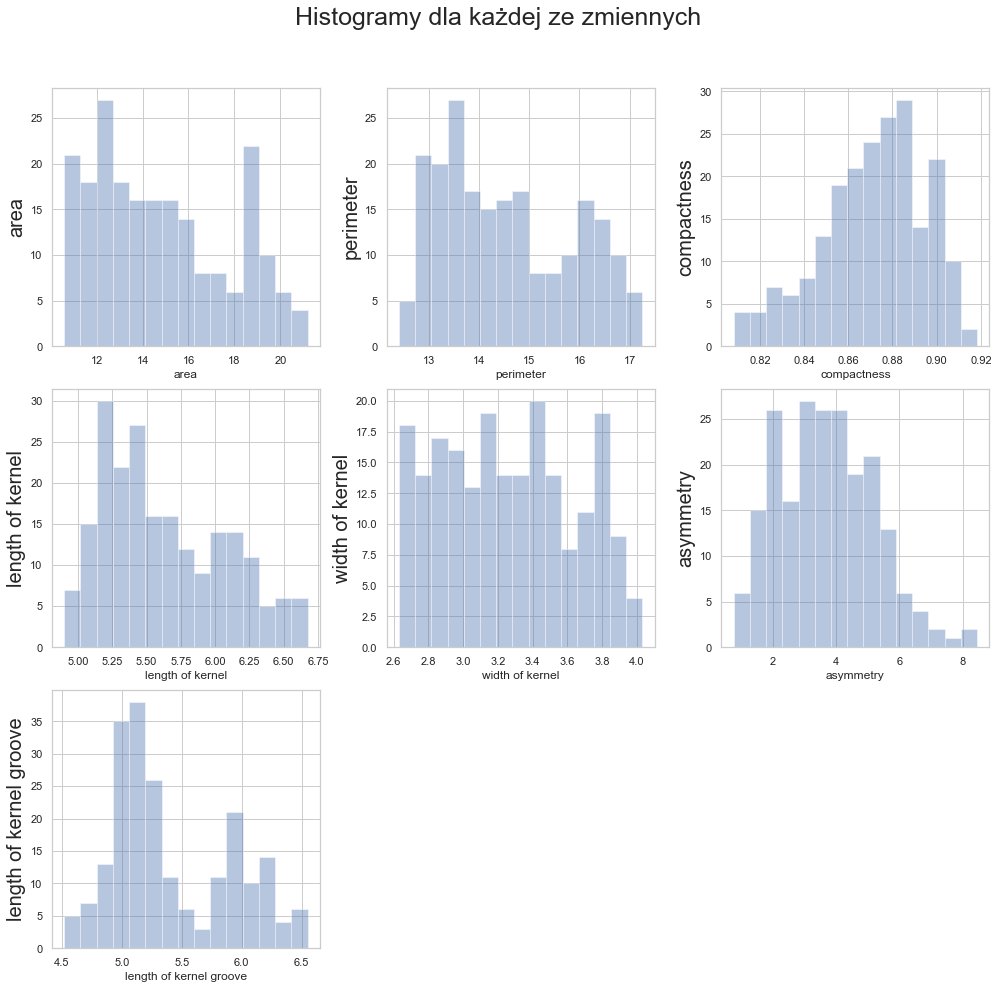

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(14,14))
fig.suptitle('Histogramy dla każdej ze zmiennych', fontsize=25)

for i, el in enumerate(feature_names):
    sns.distplot(seeds[el], ax=axes.flatten()[i],bins=15, kde=False)
    axes.flatten()[i].set_ylabel(el,fontsize=20)

#usunięcie pustych ax
fig.delaxes(axes[2,1])
fig.delaxes(axes[2,2])
plt.tight_layout() 
fig.subplots_adjust(top=0.90)

plt.show()   

Poniżej przedstawiono macierz rozproszenia (scatter matrix) w zależności od typu ziaren pszenicy. 

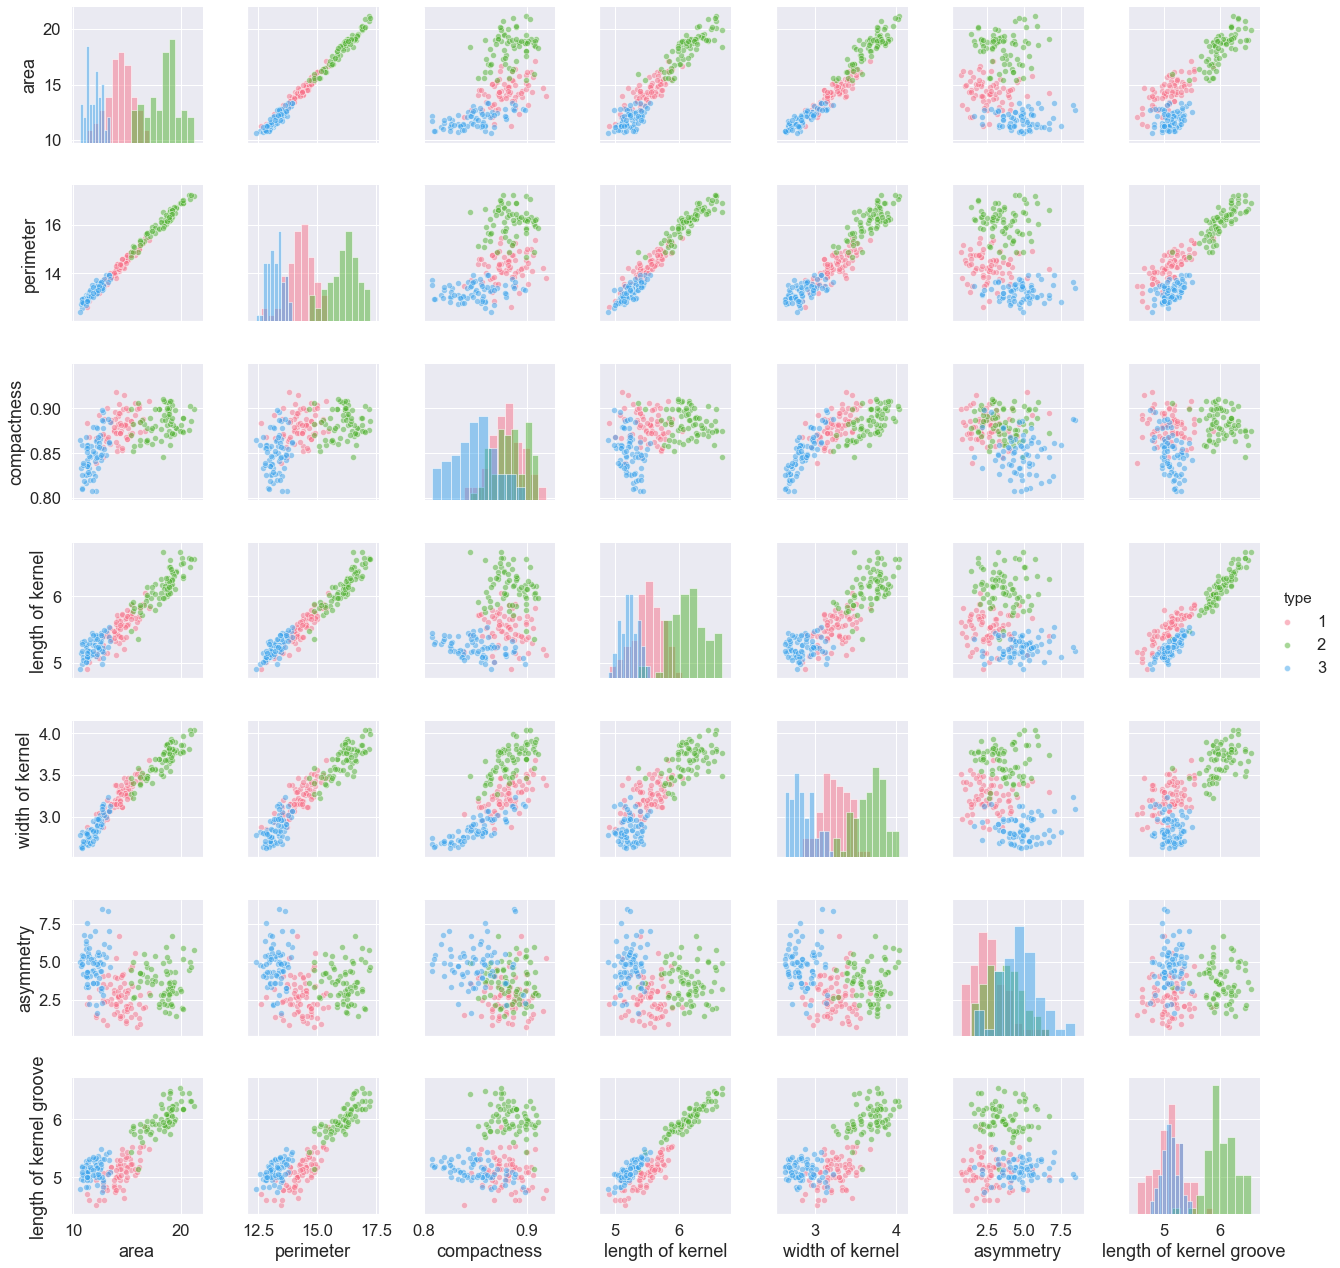

In [10]:
#powiększenie opisów
sns.set(font_scale=1.5) 
g = sns.pairplot(seeds, hue='type', palette="husl", diag_kind='hist',diag_kws = dict(alpha=0.5), plot_kws = dict(alpha=0.5))
plt.show()
sns.set(font_scale=1) 

Na podstawie powyższych wykresów można zauważyć zależności między zmiennymi a typem ziarna.

Część zależności jest bardzo logiczna - im większy obwód tym większa powierzchnia, długość, szerokość ziarna itp. Można również zauważyć iż typ 2 (zielone wartości) różnią się bardziej od pozostałych rodzaji ziarna. Ponadto z histogramu zmiennej *asymmetry* można wnioskować, iż zmienna ta niezbyt rozróżnia typy poszczególnych ziaren.

Poniżej przedstawiono średnie wartości atrybutów w każdej z grup.

In [11]:
#średnie w poszczególnych grupach
seeds.groupby('type').mean()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry,length of kernel groove
type,,,,,,,
1,14.334429,14.294286,0.880070,5.508057,3.244629,2.667403,5.087214
2,18.334286,16.135714,0.883517,6.148029,3.677414,3.644800,6.020600
3,11.873857,13.247857,0.849409,5.229514,2.853771,4.788400,5.116400


Można zauważyć, że niektóre atrybuty w większym stopniu różnią się w zależności od typu ziaren. Paramtery *area* oraz *perimeter* rozróżniają grupy, zaś *compactness*, mimo tego, iż przyjmuje wartości między 0.81, a 0.92, nie za bardzo rozróżnia grupy. 3 kolejne atrybuty również różnią się w zależności od grup, a rozróżnienie w przypadku *length of kernel groove* nie jest już tak zauważalne - można zauważyć podział między typem 2, a pozostałymi. 

## Przygotowanie danych

W celu wizualizacji danych i możliwości porównywania otrzymanych wyników, zdecydowano się użyć skalowania wielowymiarowego (ang. *MultiDimensional Scaling*). Najpierw obliczono macierz odległości między obserwacjami (pominięto typ ziaren), a następnie za pomocą funkcji *MDS* z 7 atrybutów uzyskano wyniki w formie 2 współrzędnych, które przekazują informacje na temat rozmieszczenia obserwacji względem siebie. Poprzez zastosowanie tej metody możliwa jest wizualizaja obserwacji w zależności od typu ziarna. 
Skalowanie to posłuży w tym badaniu jedynie do wizualizacji. Metody klasyfikacji oraz klasteryzacji danych wykonane zostaną na oryginalnych danych (7 atrybutów). 

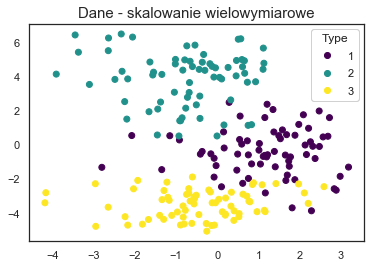

In [12]:
#brak tła w wykresach
sns.set(style="white")

seed=np.random.RandomState(seed=23)

#skalowanie
similarities= pairwise_distances(seeds.drop('type',axis=1), metric="euclidean")
mds = MDS(n_components=2, max_iter = 100, eps=1e-9, random_state=seed, dissimilarity="precomputed")
pos = mds.fit(similarities).embedding_

#wykres
fig, ax = plt.subplots()
scatter = ax.scatter(pos[:,0], pos[:,1],c= seeds['type'], cmap='viridis')
legend = ax.legend(*scatter.legend_elements(),loc="upper right", title="Type")
ax.add_artist(legend)
ax.set_title('Dane - skalowanie wielowymiarowe', fontsize=15)
plt.show()

Ze względu na różnorodne wartości zmiennych (zmienna *compactness* przyjmuje wartości 0.81-0.92, a *area* 10-21) zdecydowano się na ich unitaryzację - wartości wszystkich zmiennych będą teraz z przedziału od 0 do 1.

In [13]:
# unitaryzacja
scaler = MinMaxScaler()
#utworzenie df x oraz wektora y
X = pd.DataFrame(seeds[feature_names])
y = seeds['type']

X = scaler.fit_transform(X)

Badanie zostanie podzielone na dwie części - klasyfikację oraz klasteryzację. Do pierwszej z nich przydatne będzie rozbicie danych na zbiór uczący oraz testowy. 80% danych (168 obserwacji) należeć będzie do zbioru uczącego, a pozostałe 20% (42 obserwacje) do zbioru testowego. Podział ten zostanie wykonany losowo. 

In [14]:
np.random.seed(23)
#podział na zbiór uczący i testowy - 80/20
size = int(0.8*seeds.shape[0])
rnumber = random.sample(range(210), size)
rest = pd.DataFrame(X).index.isin(rnumber)

X_train = X[rnumber]
X_test = X[~rest]

y_train = y[rnumber]
y_test = y[~rest]

Poniżej wizualizacja obydwu zbiorów. 

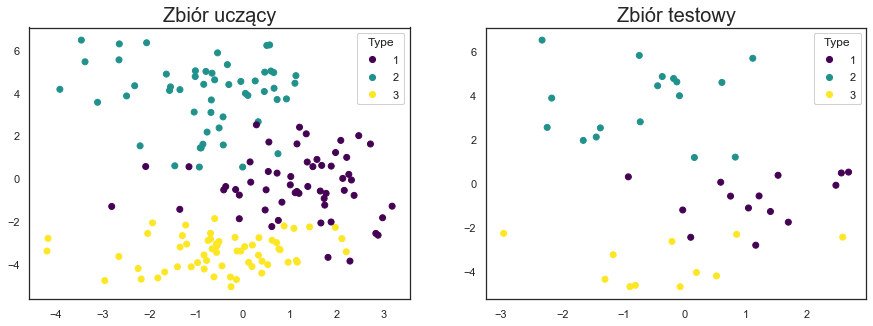

In [15]:
pos_tr = pos[rnumber]
pos_test = pos[~rest]
# wykresy
fig, ax = plt.subplots(ncols = 2, nrows=1, figsize=(15,5))
#uczący
scatter = ax[0].scatter(pos_tr[:,0], pos_tr[:,1],c= y_train, cmap='viridis')
legend1 = ax[0].legend(*scatter.legend_elements(),loc="upper right", title="Type")
ax[0].add_artist(legend1)
ax[0].set_title('Zbiór uczący', fontsize=20)
#test
scatter = ax[1].scatter(pos_test[:,0], pos_test[:,1],c= y_test, cmap='viridis')
legend2 = ax[1].legend(*scatter.legend_elements(),loc="upper right", title="Type")
ax[1].add_artist(legend2)
ax[1].set_title('Zbiór testowy', fontsize=20)
plt.show()


## Klasyfikacja

Klasyfikacja to przykład uczenia z nadzorem (ang. *supervised learning*). Posiadamy obserwacje oraz przypisaną im grupę. Celem jest stworzenie modelu, który będzie poprawnie klasyfikował dane. Model zostanie stworzony na podstawie danych trenigowych, następnie zostanie porównana jego skuteczność zarówno dla danych testowych jak i treningowych. Bardzo duża skuteczność modelu dla danych treningowych, a słaba na zbiorze testowym może świadczyć o przeuczeniu modelu. 

Przedstawione zostaną dwie metody klasyfikacji: regresja logistyczna oraz drzewo klasyfikacyjne. Następnie metody te zostaną porównane.

### Regresja logistyczna

Poniżej został stworzony model oraz predykcje zarówno dla zbioru uczącego jak i testowego

In [16]:
#model
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

#predykcja testowy
predictions_test = logmodel.predict(X_test)
#predykcja uczący
predictions_tr = logmodel.predict(X_train)

Poniżej została przedstawiana wizualizacja zbioru uczącego oraz jego predykcji.

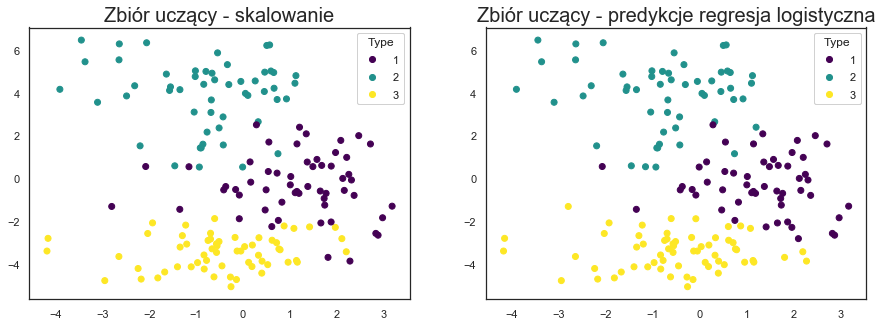

In [17]:
# wykresy
fig, ax = plt.subplots(ncols = 2, nrows=1, figsize=(15,5))
#uczący - rzeczywiste
scatter = ax[0].scatter(pos_tr[:,0], pos_tr[:,1],c= y_train, cmap='viridis')
legend1 = ax[0].legend(*scatter.legend_elements(),loc="upper right", title="Type")
ax[0].add_artist(legend1)
ax[0].set_title('Zbiór uczący - skalowanie', fontsize=20)
#uczący - predykcje
scatter = ax[1].scatter(pos_tr[:,0], pos_tr[:,1],c= predictions_tr, cmap='viridis')
legend2 = ax[1].legend(*scatter.legend_elements(),loc="upper right", title="Type")
ax[1].add_artist(legend2)
ax[1].set_title('Zbiór uczący - predykcje regresja logistyczna', fontsize=20)
plt.show()

Na podstawie wykresów można spodziewać się, iż model w znacznym stopniu dobrze sklasyfikował dane.
Poniżej przedstawiono macierz pomyłek (ang. *confusion matrix*), która przedstawia ile obserwacji należących do typu 1, zostało przypisane do typu 1, 2 oraz 3. Analogiczne wartości są przedstawione dla obserwacji należących do typu 2 i 3. 

In [18]:
cnf_matrix = metrics.confusion_matrix(y_train, predictions_tr)
print(cnf_matrix)

[[49  2  5]
 [ 1 52  0]
 [ 3  0 56]]


Warto też przedstawić następujące pojęcia związane z tym czy predykcja jest poprawna czy nie:

* TN (True Negative) - obserwacja nie należy do danej klasy (jest negatywna) i nie została do niej zakwalifikowana,

* TP (True Positive) - obserwacja należy do danej klasy (jest pozytywna) i została tam zakwalifikowana,

* FN (False Negative) - obserwacja należy do danej klasy (jest pozytywna) i nie została tam zakwalifikowana,

* FP (False Positive) - obserwacja nie należy do danej klasy (jest negatywna) i została do niej zakwalifikowana.

Poniżej przedstawiono raport z miarami klasyfikacji:

* precision = TP/(TP+FP) - jaki procent predykcji był poprawnie przypisany, dokładność pozytywnych predykcji

* recall = TP/(TP+FN) - jaki procent obserwacji należących do danego typu został poprawnie przypisany,ułamek pozytywnych predykcji poprawnie przypisany,

* f1-score = 2*(Recall * Precision) / (Recall + Precision) - ważona średnia harmoniczna *precision* oraz *recall*.

Wszystkie te miary zostały przedstawione ogólnie oraz dla każdej klasy (typu ziarna).

In [19]:
print(metrics.classification_report(y_train, predictions_tr))

              precision    recall  f1-score   support

           1       0.92      0.88      0.90        56
           2       0.96      0.98      0.97        53
           3       0.92      0.95      0.93        59

    accuracy                           0.93       168
   macro avg       0.94      0.94      0.93       168
weighted avg       0.93      0.93      0.93       168



Na podstawie macierzy pomyłek i powyższych wartości można stwierdzić, iż model dobrze klasyfikuje zbiór uczący. Pora przeprowadzić analogiczne testy dla zbioru testowego. 
Poniżej przedstawiono wykres predykcji.

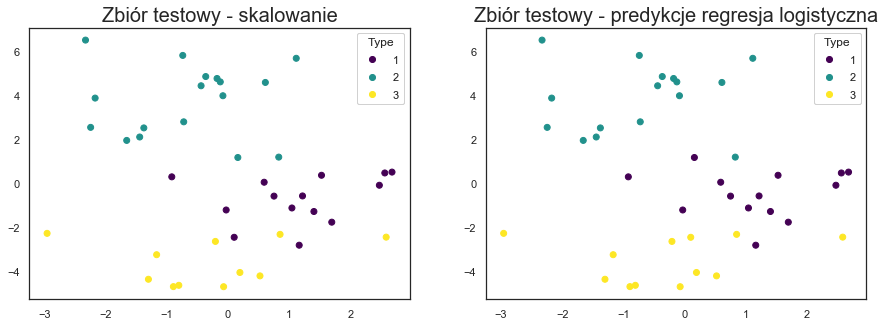

In [20]:
# wykresy
fig, ax = plt.subplots(ncols = 2, nrows=1, figsize=(15,5))
#testowy - rzeczywiste
scatter = ax[0].scatter(pos_test[:,0], pos_test[:,1],c= y_test, cmap='viridis')
legend1 = ax[0].legend(*scatter.legend_elements(),loc="upper right", title="Type")
ax[0].add_artist(legend1)
ax[0].set_title('Zbiór testowy - skalowanie', fontsize=20)
#testowy - predykcje
scatter = ax[1].scatter(pos_test[:,0], pos_test[:,1],c= predictions_test, cmap='viridis')
legend2 = ax[1].legend(*scatter.legend_elements(),loc="upper right", title="Type")
ax[1].add_artist(legend2)
ax[1].set_title('Zbiór testowy - predykcje regresja logistyczna',fontsize=20)
plt.show()

Analogicznie przedstawiona została macierz pomyłek oraz raport klasyfikacji.

In [21]:
cnf_matrix = metrics.confusion_matrix(y_test, predictions_test)
print(cnf_matrix)

[[13  0  1]
 [ 1 16  0]
 [ 0  0 11]]


In [22]:
print(metrics.classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

           1       0.93      0.93      0.93        14
           2       1.00      0.94      0.97        17
           3       0.92      1.00      0.96        11

    accuracy                           0.95        42
   macro avg       0.95      0.96      0.95        42
weighted avg       0.95      0.95      0.95        42



Model ten sprawuje się gorzej dla zbioru testowego niż uczącego. Jednakże otrzymane wyniki dalej są na zadawalającym poziomie.

### Drzewo klasyfikacyjne

Drugim badanym modelem jest drzewo klasyfikacyjne. Poniżej stworzono model, jako maksymalną głebokość drzewa ustalono liczbę 4, powinno to ograniczyć za duże dopasowanie drzewa do zbioru uczącego. Następnie dokonano predykcje dla zbioru uczącego i testowego.

In [23]:
#Tworzenie drzewa
dtree = DecisionTreeClassifier(max_depth =4)
dtree.fit(X_train,y_train)

#predykcja testowy
predictions_test = dtree.predict(X_test)
#predykcja uczący
predictions_tr = dtree.predict(X_train)

Analogicznie do powyższej analizy, poniżej przedstawiono wykres predykcji dla zbioru uczącego. 

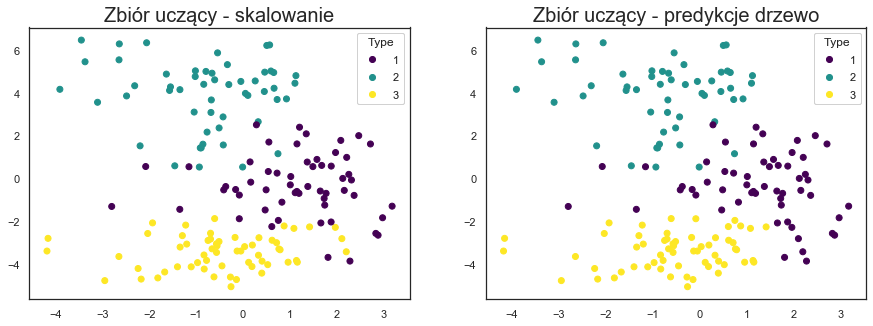

In [24]:
# wykresy
fig, ax = plt.subplots(ncols = 2, nrows=1, figsize=(15,5))
#uczący - rzeczywiste
scatter = ax[0].scatter(pos_tr[:,0], pos_tr[:,1],c= y_train, cmap='viridis')
legend1 = ax[0].legend(*scatter.legend_elements(),loc="upper right", title="Type")
ax[0].add_artist(legend1)
ax[0].set_title('Zbiór uczący - skalowanie', fontsize=20)
#uczący - predykcje
scatter = ax[1].scatter(pos_tr[:,0], pos_tr[:,1],c= predictions_tr, cmap='viridis')
legend2 = ax[1].legend(*scatter.legend_elements(),loc="upper right", title="Type")
ax[1].add_artist(legend2)
ax[1].set_title('Zbiór uczący - predykcje drzewo', fontsize=20)
plt.show()

Na podstawie powyższych wykresów można spodziewać się dobrej oceny modelu.

Poniżej macierz pomyłek i raport klasyfikacji.

In [25]:
cnf_matrix = metrics.confusion_matrix(y_train, predictions_tr)
print(cnf_matrix)

[[53  0  3]
 [ 0 53  0]
 [ 3  0 56]]


In [26]:
print(metrics.classification_report(y_train, predictions_tr))

              precision    recall  f1-score   support

           1       0.95      0.95      0.95        56
           2       1.00      1.00      1.00        53
           3       0.95      0.95      0.95        59

    accuracy                           0.96       168
   macro avg       0.97      0.97      0.97       168
weighted avg       0.96      0.96      0.96       168



Jak widać model prawie idealnie przypisuje odpowiednie klasy zmiennym. Pora teraz zbadać jego wyniki dla danych testowych. Poniżej wykres wizualizujący predykcje dla danych testowych.

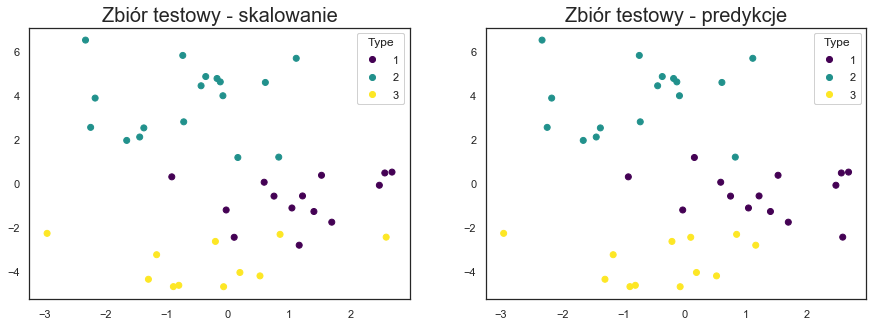

In [27]:
# wykresy
fig, ax = plt.subplots(ncols = 2, nrows=1, figsize=(15,5))
#testowy - rzeczywiste
scatter = ax[0].scatter(pos_test[:,0], pos_test[:,1],c= y_test, cmap='viridis')
legend1 = ax[0].legend(*scatter.legend_elements(),loc="upper right", title="Type")
ax[0].add_artist(legend1)
ax[0].set_title('Zbiór testowy - skalowanie', fontsize=20)
#testowy - predykcje
scatter = ax[1].scatter(pos_test[:,0], pos_test[:,1],c= predictions_test, cmap='viridis')
legend2 = ax[1].legend(*scatter.legend_elements(),loc="upper right", title="Type")
ax[1].add_artist(legend2)
ax[1].set_title('Zbiór testowy - predykcje', fontsize=20)
plt.show()

Można zauważyć, iż w 'granicznych' przypadkach model niepoprawnie przypisał klasy, jednak ogólnie można spodziewać się dobrego wyniku. Poniżej macierz pomyłek oraz raport klasyfikacji.

In [28]:
cnf_matrix = metrics.confusion_matrix(y_test, predictions_test)
print(cnf_matrix)

[[12  0  2]
 [ 1 16  0]
 [ 1  0 10]]


In [29]:
print(metrics.classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

           1       0.86      0.86      0.86        14
           2       1.00      0.94      0.97        17
           3       0.83      0.91      0.87        11

    accuracy                           0.90        42
   macro avg       0.90      0.90      0.90        42
weighted avg       0.91      0.90      0.91        42



Widać, iż model jest mniej skuteczny dla danych testowych, jednak wyniki dalej są dobre.

Poniżej przedstawiono wizualizacje drzewa - przedstawione są poszczególne podziały oraz końcowe przypisanie do klasy.

C:\Users\wikis\anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


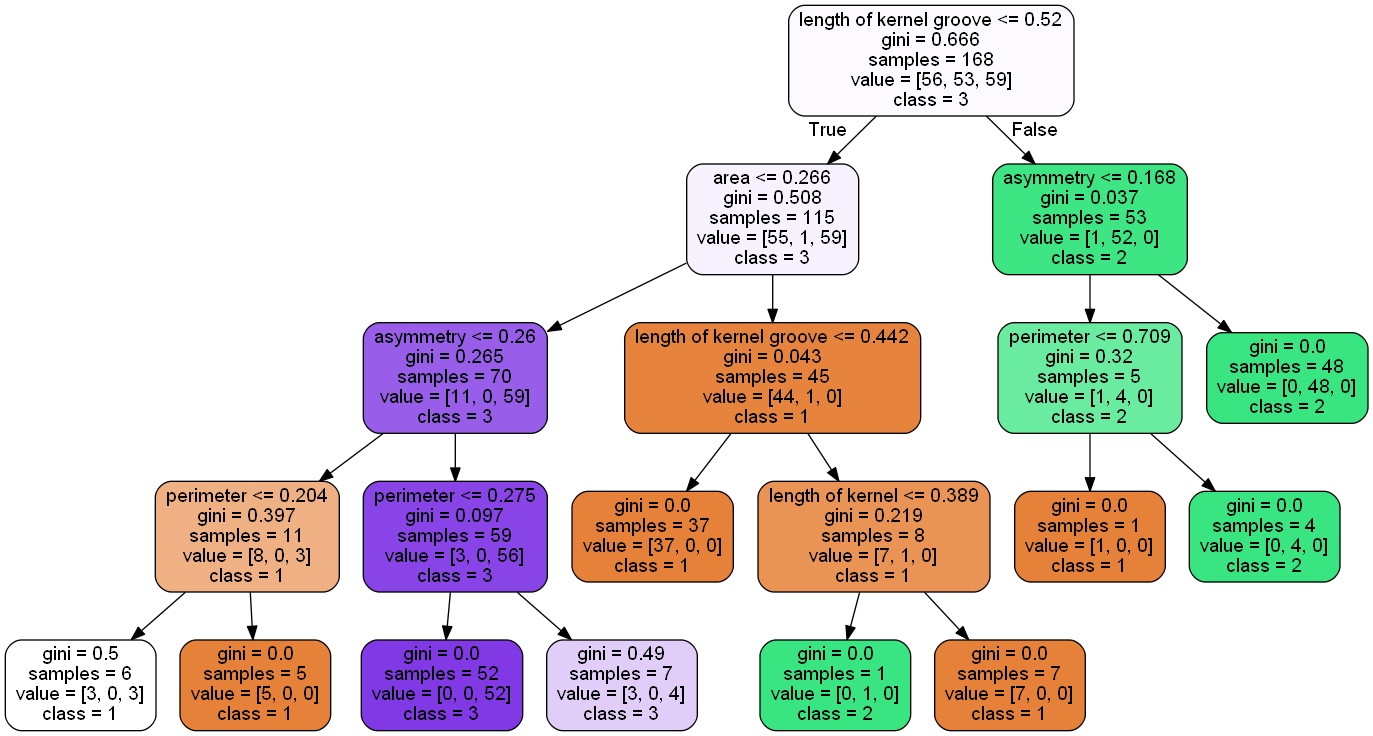

In [30]:
#biblioteki niezbędne do wizualizacji drzewa
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

dot_data = StringIO()  
export_graphviz(dtree, out_file=dot_data, feature_names=feature_names, class_names=['1','2','3'], filled=True, rounded=True)
 
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())  

### Porównanie oraz wnioski

Obydwa modele lepiej sprawdziły się dla danych uczących niż dla testowych. Wyniki obydwu metod są bardzo do siebie podobne. Nie można stwierdzić, iż jeden model okazał się być dużo lepszy od drugiego. 
Jednakże skłaniałabym się, by wybrać drzewo klasyfikacyjne, jest to bardziej złożony algorytm i możliwe jest dopasowanie parametrów drzewa (np. maksymalną głębokość) w inny sposób poprawiając jego wyniki. Można również zostosować bardziej złożone algorytmy tworzenia drzew np. Random Forest

## Klasteryzacja

Klasteryzacja to przykład uczenia bez nadzoru (ang. unsupervised learning). Posiadamy obserwacje, lecz nie posiadamy przypisanej do niej klasy. Celem klasteryzacji jest pogrupowanie danych na podstawie ich podobieństwa, bez znajomości ich klas. Nie ma sensu więc tworzyć macierzy pomyłek oraz nie ma potrzeby podziału danych na testowe oraz treningowe. Istnieją metody, które pomagają wybrać odpowiednią ilość klastrów dla danych. 

Dla danych użytych do badania mamy przypisane już klasy - wiadomo więc jaką ilość klastrów należy stworzyć. Badanie zostanie przeprowadzone dla danych wykluczając zmienną *type*. Następnie zwizualizowane zostaną przypisane klastry oraz rzeczywiste klasy danych. 

Przedstawione zostaną dwie metody klasteryzacji: grupowanie hierarchiczne oraz metoda k-średnich.

### Grupowanie hierarchiczne
Jest to metoda, która ma na celu zbudowanie hierarchii klastrów. Służy do dzielenia obserwacji na grupy bazując na podobieństwach między nimi. W metodzie tej na wstępie nie jest konieczne określenie liczby tworzonych klastrów. Jednak w tym przypadku liczba ta jest znana - wynosi 3. 

Najpierw zostanie obliczona macierz odległości między zmiennymi - w badaniu zostanie obliczona odległość Euklidesowa. Następnie należy wybrać metodę połączenia, określa ona jak definiowana jest odległość między dwoma klastrami. W zależnośći od jej wyboru przypisanie do poszczególnych grup różni się. W badaniu zostaną przedstawione 4 metody:

* Warda - Odległość między dwoma klastrami jest sumą kwadratów odchyleń od punktów do centroidów. Ten sposób dąży do zminimalizowania sumy kwadratów wewnątrz klastra.

* Pojedyncze połączenie - Odległość między dwoma klastrami jest minimalną odległością między obserwacją w jednym klastrze a obserwacją w innym klastrze. Sprawdza się, gdy klastry są wyraźnie oddzielone.

* Średnie połączenie - Odległość między dwoma klastrami jest średnią odległością między obserwacją w jednym klastrze a obserwacją w innym klastrze.

* Kompletne połączenie - Odległość między dwoma klastrami jest maksymalną odległością między obserwacją w jednym klastrze a obserwacją w innym klastrze. Może być wrażliwy na występowanie outlierów. 

Poniżej wizualizacja przypisanych grup dla wyżej wymienionych metod.

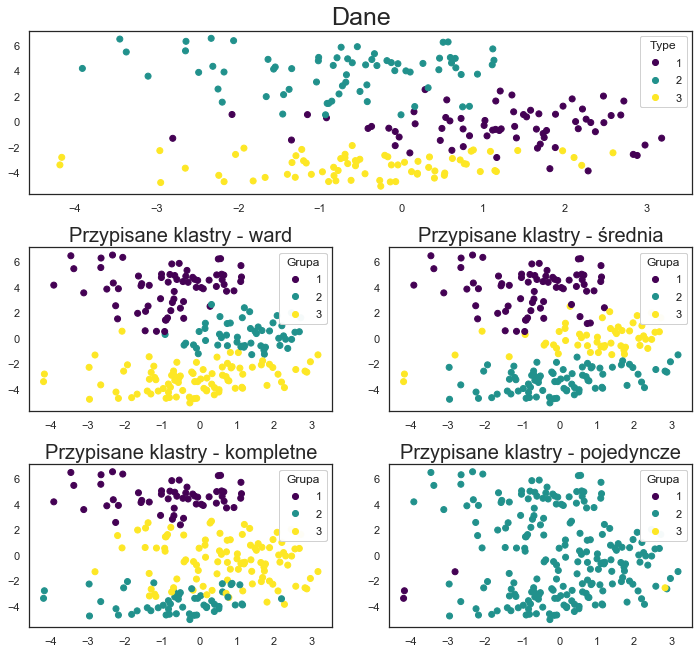

In [31]:
fig = plt.figure(figsize=(15,15))
ax1 = plt.subplot2grid((5,3), (0,0), colspan=2)
scatter = ax1.scatter(pos[:,0], pos[:,1],c= seeds['type'], cmap='viridis')
legend = ax1.legend(*scatter.legend_elements(),loc="upper right", title="Type")
ax1.add_artist(legend)
ax1.set_title('Dane', fontsize=25)


ax2 = plt.subplot2grid((5,3), (1,0))

#tworzenie macierzy odległości 'ward'
distance_matrix_ward = shc.linkage(X, 'ward')
#3 klasy
predicted_cluster = shc.fcluster(distance_matrix_ward, 3, criterion='maxclust')
scatter = ax2.scatter(pos[:,0], pos[:,1],c= predicted_cluster, cmap='viridis')
legend2 = ax2.legend(*scatter.legend_elements(),loc="upper right", title="Grupa")
ax2.add_artist(legend2)
ax2.set_title('Przypisane klastry - ward', fontsize=20)


ax3 = plt.subplot2grid((5,3), (1,1))

#tworzenie macierzy odległości 'average'
distance_matrix_average = shc.linkage(X, 'average')
#3 klasy
predicted_cluster = shc.fcluster(distance_matrix_average, 3, criterion='maxclust')
scatter = ax3.scatter(pos[:,0], pos[:,1],c= predicted_cluster, cmap='viridis')
legend2 = ax3.legend(*scatter.legend_elements(),loc="upper right", title="Grupa")
ax3.add_artist(legend2)
ax3.set_title('Przypisane klastry - średnia', fontsize=20)

ax4 = plt.subplot2grid((5,3), (2,0))


#tworzenie macierzy odległości 'complete'
distance_matrix_complete = shc.linkage(X, 'complete')
#3 klasy
predicted_cluster = shc.fcluster(distance_matrix_complete, 3, criterion='maxclust')
scatter = ax4.scatter(pos[:,0], pos[:,1],c= predicted_cluster, cmap='viridis')
legend2 = ax4.legend(*scatter.legend_elements(),loc="upper right", title="Grupa")
ax4.add_artist(legend2)
ax4.set_title('Przypisane klastry - kompletne', fontsize=20)

ax5 = plt.subplot2grid((5,3), (2,1))

#tworzenie macierzy odległości 'single'
distance_matrix_single = shc.linkage(X, 'single')
#3 klasy
predicted_cluster = shc.fcluster(distance_matrix_single, 3, criterion='maxclust')
scatter = ax5.scatter(pos[:,0], pos[:,1],c= predicted_cluster, cmap='viridis')
legend2 = ax5.legend(*scatter.legend_elements(),loc="upper right", title="Grupa")
ax5.add_artist(legend2)
ax5.set_title('Przypisane klastry - pojedyncze', fontsize=20)

fig.tight_layout()
plt.show()



Należy być świadomym, iż nazwy grup na tym wykresie nie są istotne - grupa 1 nie musi odpowiadać wartości 1 dla typu.
Wizualnie można jednoznacznie stwierdzić iż, metoda oparta na pojedynczym połączeniu najgorzej pogrupowała dane. Metoda Ward'a oraz ta oparta na średniej poradziły sobie najlepiej. Można zauważyć niewielkie różnice. 

Poniżej przedstawione zostaną dendrogramy, tj. łączenie danych. Zakładając, iż nie wiemy jaka powinna być liczba klastrów za pomocą tych wykresów można wizualnie stwierdzić jaka liczba będzie pożądana. Dendrogramy przedstawione zostaną dla każdej z metod.

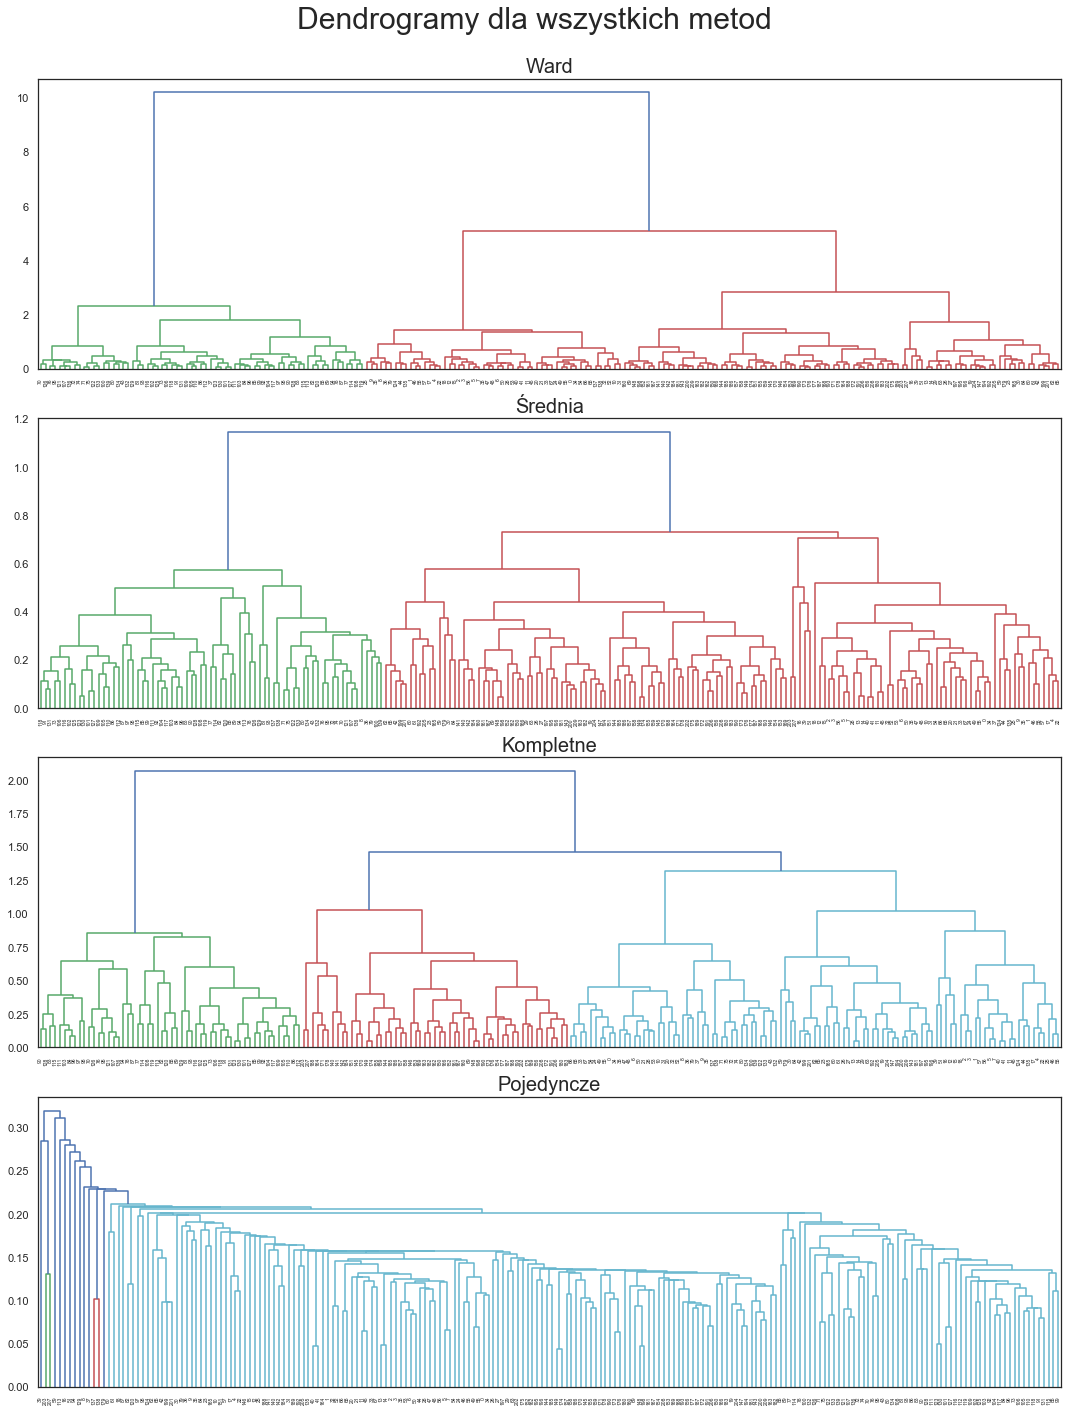

In [32]:
# wykresy dendrogramy
fig, ax = plt.subplots(ncols = 1, nrows=4, figsize=(15,20))
fig.suptitle('Dendrogramy dla wszystkich metod', fontsize=30)

shc.dendrogram(distance_matrix_ward, ax=ax[0])
ax[0].set_title('Ward', fontsize=20)

shc.dendrogram(distance_matrix_average, ax=ax[1])
ax[1].set_title('Średnia', fontsize=20)

shc.dendrogram(distance_matrix_complete, ax=ax[2])
ax[2].set_title('Kompletne', fontsize=20)

shc.dendrogram(distance_matrix_single, ax=ax[3])
ax[3].set_title('Pojedyncze', fontsize=20)

plt.tight_layout() 
fig.subplots_adjust(top=0.93)
plt.show()



Z powyższych dendrogramów można wywnioskować, iż metoda średniej oraz Warda sugerują podział na 2 grupy. Można jednak zaobserwować w jaki sposób łączone są dane. Ponownie można stwierdzić iż metoda opierająca się na pojedynczym połączeniu jest najgorsza.

### Metoda k-średnich

Jest to metoda należaca do grupy algorytmów analizy skupień tj. analizy polegającej na szukaniu i wyodrębnianiu grup obiektów podobnych (skupień). Reprezentuje ona grupę algorytmów niehierarchicznych. Konieczne jest wcześniejsze podanie liczby grup. 
Przy pomocy metody k-średnich zostanie utworzonych k różnych możliwie odmiennych skupień. Algorytm ten polega na przenoszeniu obiektów ze skupienia do skupienia tak długo aż zostaną zoptymalizowane zmienności wewnątrz skupień oraz pomiędzy skupieniami. Podobieństwo w skupieniu powinno być jak największe, zaś osobne skupienia powinny się maksymalnie od siebie różnić.

Poniżej przedstawiono wykres wizualizujący przypisanie do grup. 

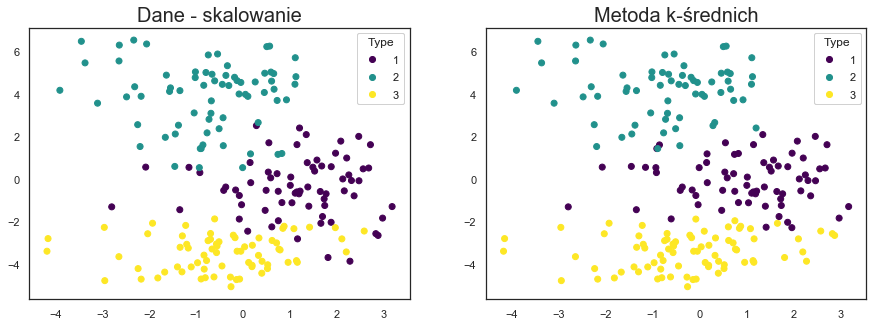

In [33]:
# metoda k-średnich
cluster = KMeans(n_clusters=3, random_state=14)
#dodano 1, bo metoda przydziela klastry od 0
cluster_labels = cluster.fit_predict(X)+1

# wykresy
fig, ax = plt.subplots(ncols = 2, nrows=1, figsize=(15,5))
#rzeczywiste
scatter = ax[0].scatter(pos[:,0],pos[:,1],c= y, cmap='viridis')
legend1 = ax[0].legend(*scatter.legend_elements(),loc="upper right", title="Type")
ax[0].add_artist(legend1)
ax[0].set_title('Dane - skalowanie', fontsize=20)
#wyniki k-średnich
scatter = ax[1].scatter(pos[:,0],pos[:,1], c=cluster_labels, cmap='viridis')
legend2 = ax[1].legend(*scatter.legend_elements(),loc="upper right", title="Type")
ax[1].add_artist(legend2)
ax[1].set_title('Metoda k-średnich', fontsize=20)
plt.show()



Można ocenić, iż metoda ta bardzo dobrze utworzyła 3 grupy, jedynie na podstawie danych. W cześci poświęconej przedstawieniu danych zostały przedstawione średnie wartości parametrów w zależności od typu ziarna. Można było wtedy zauważyć, iż rozróżnienie w grupach jest widoczne. Dzięki temu metoda ta dobrze się sprawdziła.

Poniżej przedstawiono ponownie średnie w grupach dla danych po unitaryzacji oraz centroidy klastrów dla metody k-średnich.

In [34]:
pd.DataFrame(X).groupby(y).mean()

,0,1,2,3,4,5,6
type,,,,,,,
1,0.353582,0.389315,0.653085,0.342938,0.438082,0.247345,0.279771
2,0.731283,0.769776,0.684366,0.703282,0.746553,0.374430,0.739340
3,0.121233,0.173111,0.374851,0.186100,0.159495,0.523125,0.294141


In [35]:
s = pd.Series([1, 2, 3])
pd.DataFrame(cluster.cluster_centers_).set_index(s)

,0,1,2,3,4,5,6
1,0.383490,0.419841,0.671204,0.364685,0.468499,0.264177,0.318384
2,0.757333,0.793744,0.694192,0.730038,0.769501,0.367576,0.757093
3,0.123334,0.175137,0.378179,0.186710,0.162527,0.498569,0.279288


Można zauważyć, iż wartości te są zblizone do siebie.

## Podsumowanie

Ciężko jest porównać ze sobą klasyfikację oraz klasteryzację - są to metody, które różnią się w podstawowych założeniach. Zostały przedstawione 2 metody klasyfikacji oraz 2 metody klasteryzacji. Nie jest możliwe wyłonienie najgorszej oraz najlepszej z nich. Jednakże za pomocą wszystkich z nich osiągnięto dość dobre wyniki. 

W powyższym sprawozdaniu został osiągnięty jego cel - wybrano dane oraz wykonana została ich analiza. 